In [10]:
import pandas as pd
import numpy as np
import re

#for getting the fisher exact test
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()


from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.base import ClusterMixin, BaseEstimator
from scipy.spatial.distance import pdist, squareform
cohort_root = '../data/cohort_data.tsv'

In [15]:
class LNDataset():
    
    data_columns = ['Dummy ID', 
               'Affected Lymph node UPPER',
               'Feeding tube 6m', 
               'Aspiration rate(Y/N)',
                'Aspiration rate Pre-therapy',
                'Aspiration rate Post-therapy',
                'Neck boost (Y/N)',
               'Gender',
               'Tm Laterality (R/L)']
    ambiguous_nodes = set(['2/3','3/4','2/3/4','/3','2/','-R4'])
    ln_features = ['id','nodes','position','gender','scores', 'similarity',
               'Aspiration_rate_Post-therapy','Aspiration_rate_Pre-therapy',
               'Feeding_tube_6m','Neck_boost']
    js_name_dict = {'Gender': 'gender', 
                 'Tm Laterality (R/L)': 'position', 
                'Feeding tube 6m': "Feeding_tube_6m",
                'Aspiration rate Pre-therapy': 'Aspiration_rate_Pre-therapy',
                'Aspiration rate Post-therapy': 'Aspiration_rate_Post-therapy',
                'Neck boost (Y/N)': 'Neck_boost'}
    
    def __init__(self,
                 cohort_data = cohort_root, 
                 adjacency_path = './connectivity_646.csv'):

        self.adjacency = pd.read_csv(adjacency_path, index_col = 0)
        self.node_list = sorted(self.adjacency.columns)
        
        self.get_data(cohort_data)
        
        self.setup_grams()
        
    def get_data(self, cohort_data):
        if isinstance(cohort_data, pd.DataFrame):
            self.data = cohort_data
        else:
            try:
                self.data = pd.read_csv(cohort_data, engine='python',
                           sep = '\t',
                           index_col=0, 
                           usecols = LNDataset.data_columns,
                           dtype = {'Affected Lymph node UPPER': str})
            except:
                self.data = pd.read_csv(cohort_data, engine='python',
                           sep = ',',
                           index_col=0, 
                           usecols = LNDataset.data_columns,
                           dtype = {'Affected Lymph node UPPER': str})
        self.data = self.data.dropna(subset=['Affected Lymph node UPPER'])
        self.data.index.rename('id',inplace = True)
        self.data.sort_index(inplace=True)
        
    def setup_grams(self):
        #extract all the node names and such
        self.left_nodes = ['L'+n for n in self.adjacency.columns]
        self.right_nodes = ['R'+n for n in self.adjacency.columns]
        self.rpln = ['RRPLN', 'LRPLN']
        self.nodes = self.left_nodes + self.right_nodes
        self.all_nodes = set(self.nodes)
        self.node_to_index = {word: position for position, word in enumerate(self.nodes)}
        
        self.clean_ln_data()
        self.index = self.data.index
        self.ids = self.index.values
        self.monograms = self.get_monograms(self.data)
        self.dual_bigrams = self.setup_bigrams()
        self.dual_monograms = self.get_dual_monograms()
        self.spatial = lambda : pd.concat([self.dual_bigrams, self.dual_monograms], axis = 1)
        self.nonspatial = lambda : self.dual_monograms
        
    def clean_names(self,x):
        return [re.sub('^[LR]\s*','',x) for x in x.columns]
        
    def clean_names_string(self, x):
        return ''.join(self.clean_names(x))
        
    def get_dual_monograms(self):
        lgrams = self.monograms.loc[:,self.left_nodes]
        rgrams = self.monograms.loc[:,self.right_nodes]
        lnames = self.clean_names_string(lgrams)
        rnames = self.clean_names_string(rgrams)
        assert(lnames == rnames)
        df_values = lgrams.values + rgrams.values
        dual_monograms = pd.DataFrame(df_values, columns = self.clean_names(lgrams), index = lgrams.index)
        return dual_monograms
        
    def setup_bigrams(self):
        l_bigrams = self.bigramize(self.monograms.loc[:, self.left_nodes], 'L')
        r_bigrams = self.bigramize(self.monograms.loc[:, self.right_nodes], 'R')
        rnames = self.clean_names_string(l_bigrams)
        lnames = self.clean_names_string(r_bigrams)
        assert(rnames == lnames)
        assert(np.all(l_bigrams.index == r_bigrams.index))
        dual_bigrams = pd.DataFrame(l_bigrams.values +r_bigrams.values, 
                               columns = self.clean_names(l_bigrams),
                               index = self.index)
        return dual_bigrams
        
    #helper functions
    def parse_lymph_nodes(self, node_string):
        #the data apparently has just '2' when theres a '2A' and '2B'
        node_string = re.sub('L2,*','L2A, L2B,', node_string)
        node_string = re.sub('R2,*','R2A, R2B,', node_string)
        node_string = re.sub('R RPLN', 'RRPLN', node_string)
        node_string = re.sub('L RPLN', 'LRPLN', node_string)
        nodes = [n.strip() for n in node_string.split(',')]
        #remove the node with 'in-between' labeled nodes?
        for n in nodes:
            if n in LNDataset.ambiguous_nodes:
                return np.NaN
        nodes = [n for n in nodes if n in self.all_nodes]
        return nodes if len(nodes) > 0 else np.NaN
    
    def clean_ln_data(self):
        self.data['nodes'] = (self.data.copy())['Affected Lymph node UPPER'].apply(self.parse_lymph_nodes).values
        self.data = self.data.dropna(subset=['nodes'])

    def get_monograms(self, data):
        monograms = pd.DataFrame(index = self.index, columns = self.nodes, dtype = np.int32).fillna(0)
        for pos, p in enumerate(data['nodes']):
            index = self.index[pos]
            for lymph_node in p:
                monograms.loc[index, lymph_node] = 1
        return monograms

    def get_bigram_names(self):
        bigram_set = set([])

        for i, name in enumerate(self.node_list):
            for i2 in range(i+1, len(self.node_list)):
                if self.adjacency.iloc[i,i2] > 0:
                    bigram_set.add(name + self.node_list[i2])
        ' '.join(sorted(bigram_set))
        bigram_names = (sorted(bigram_set))
        return bigram_names, bigram_set

    def bigramize(self, v, side):
        #shoudl take a unilateral (left or right) matrix of affected lypmh nnodes
        assert(v.shape[1] == self.adjacency.shape[1])
        col_names = list(v.columns)
        clean = lambda x:  re.sub('^[LR]\s*','', x)
        bigrams = []
        names = []
        _, bigram_set = self.get_bigram_names()
        for i, colname in enumerate(col_names):
            nodename = clean(colname)
            for i2 in range(i+1, v.shape[1]):
                colname2 = col_names[i2]
                bigram_name = nodename + clean(colname2)
                if bigram_name in bigram_set:
                    if bigram_name not in names:
                        names.append(side + bigram_name)
                    bigram_vector = v[colname].values * v[colname2].values
                    bigrams.append(bigram_vector.reshape(-1,1))
        return pd.DataFrame(np.hstack(bigrams), columns = names, index = self.data.index)
    
    def formatted_features(self):
        datacopy = self.data.copy()
        datacopy.columns = [LNDataset.js_name_dict.get(x, x) for x in datacopy.columns]
        datacopy.nodes = rename_nodes(datacopy.nodes)
        return datacopy
    
def rename_nodes(nodes):
    name_dict = {'RRPLN':'RRP', 'LRPLN':'LRP'}
    rename_node = lambda nodelist: [name_dict.get(x,x) for x in nodelist]
    return nodes.apply(lambda x: rename_node(x))

In [23]:
def l1(x1, x2):
    return np.sum(np.abs(x1-x2))

def tanimoto_dist(x1, x2):
    if l1(x1, x2) == 0:
        return 0
    tanimoto = x1.dot(x2)/(x1.dot(x1) + x2.dot(x2) - x1.dot(x2))
    #guadalupe used 1 - similarity for her clustering
    return 1 - tanimoto

def l2(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

def dist_matrix(x, dist_func, scale = False):
    n = x.shape[0]
    distance = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            distance[i,j] = (dist_func(x[i], x[j]))
    distance += distance.transpose()
    if scale:
        distance = (distance - distance.min())/(distance.max() - distance.min())
    return distance

def sim_matrix(x, dist_func, zero_axis = True):
    dist = dist_matrix(x, dist_func, scale = True)
    sim = 1 - dist
    if zero_axis:
        sim[np.arange(x.shape[0]), np.arange(x.shape[0])] = 0
    return sim

def LN_similarity_result_matrix(ln_dataset):
    x = ln_dataset.spatial().values
    ids = ln_dataset.index.values.ravel()
    similarity = sim_matrix(x, dist_func = tanimoto_dist)
    most_similar_ids = []
    similarity_scores = []
    for pos, sim_row in enumerate(similarity):
        sorted_args = np.argsort(-sim_row).ravel()
        sorted_sims = sim_row[sorted_args]
        sorted_ids = ids[sorted_args]
        nonzero = np.argwhere(sorted_sims > 0).ravel()
        sorted_sim = np.insert(sorted_sims[nonzero], 0, 1)
        sorted_ids = np.insert(sorted_ids[nonzero], 0, ids[pos])
        most_similar_ids.append(list(sorted_ids))
        similarity_scores.append(list(sorted_sim))
    db = pd.DataFrame({'similarity':most_similar_ids, 'scores':similarity_scores},
                     index = ln_dataset.index)
    return(db)
    
class FClusterer(ClusterMixin, BaseEstimator):

    def __init__(self, n_clusters, dist_func = tanimoto_dist, link = 'weighted', criterion = 'maxclust'):
        self.link = link
        self.dist_func = dist_func if link not in ['median', 'ward', 'centroid'] else 'euclidean'
        self.t = n_clusters
        self.criterion = criterion
        
    def get_leaves(self, x):
        clusters = linkage(x, method = self.link, metric = self.dist_func, optimal_ordering = True)
        dendro = dendrogram(clusters)
        return np.array(dendro['ivl']).astype('int32')
    
    def fit_predict(self, x, y = None):
        clusters = linkage(x, method = self.link, metric = self.dist_func, optimal_ordering = True)
        return fcluster(clusters, self.t, criterion = self.criterion)
    
def ordinalize(array):
    vals = np.unique(array)
    mapkey = {val: pos+1 for pos,val in enumerate(vals)}
    array = np.array([mapkey[a] for a in array])
    return array 

def get_clustering(x, k=6, max_frac=.5, as_df = True):
    fcluster = FClusterer(27)
    gcluster = FClusterer(k)
    clusters = fcluster.fit_predict(x)
    groups = gcluster.fit_predict(x)
    c, g = ordinalize(clusters), ordinalize(groups)
    leaves = fcluster.get_leaves(x)
    return c, g, leaves

def save_clustering(dataset, target_file, k =6, g = None, bigrams = True):
    x = dataset.spatial().values if bigrams else dataset.nonspatial().values
    if g is None:
        g = x.shape[0]
    clusters, groups, leaves = get_clustering(x, k, g)
    #leaves is  something, groups is big clusters, clusters is small clusters
    df_dict = {'clusterId': leaves, 'groupId': groups, 'dendrogramId': clusters}
    df = pd.DataFrame(df_dict, index = dataset.index)
    df.index.rename('patientId', inplace = True)
    df.to_csv(target_file)
    return df
    
def randomized_cohort_data(df, frac = .6):
    if isinstance(df, LNDataset):
        df = df.data
    newdata = df.copy()
    for col in newdata.columns:
        newdata[col] = newdata[col].sample(frac=1, replace=True).values
    newdata.index = np.arange(newdata.shape[0]) + 1
    newdata.index.rename('Dummy ID',inplace=True)
    newdata = newdata.sample(frac=frac,replace=False)
    return newdata.dropna()
    
def dataset_to_json(dataset, path = 'example_dataset.json'):
    #todo: get scores
    data = dataset.formatted_features()
    similarity_data = LN_similarity_result_matrix(dataset)
    data = pd.concat([data, similarity_data],axis=1)
    data['id'] = data.index.values.astype('int32')
    data.to_json(path, orient='records')
    
def export_dataset(dataset,
                   target_json = 'example_patients.json',
                   target_bigram_cluster_csv = 'example_bigram_clusters.csv',
                   target_unigram_cluster_csv = 'example_unigram_clusters.csv'):
    #can be passed a LNDataset or a valid csv string with cohort data, and exports the js frontend files
    if isinstance(dataset, str):
        dataset = LNDataset(dataset)
    dataset_to_json(dataset, target_json)
    save_clustering(dataset, target_bigram_cluster_csv, bigrams = True)
    save_clustering(dataset, target_unigram_cluster_csv, bigrams = False)
    
def gen_random_cohort(patient_path=cohort_root, 
                     target_csv ='example_patients.csv',
                     target_json ='example_patients.json',
                     target_bigram_cluster_csv = 'example_bigram_clusters.csv',
                     target_unigram_cluster_csv = 'example_unigram_clusters.csv'):
    dataset = LNDataset(patient_path)
    data = randomized_cohort_data(dataset.data)
    dataset = LNDataset(data.sort_index())
    if target_csv is not None:
        try:
            dataset.data.drop(['nodes'],axis=1).to_csv(target_csv)
            print('saved synthetic data csv to', target_csv)
        except:
            print('error saving synthetic data as csv')
    export_dataset(dataset, target_json, target_bigram_cluster_csv, target_unigram_cluster_csv)
    return dataset
   

saved synthetic data csv to example_patients.csv


PermissionError: [Errno 13] Permission denied: 'example_unigram_clusters.csv'

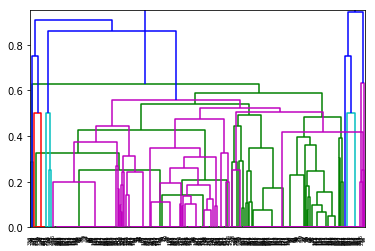

In [24]:
sd = gen_random_cohort()

In [18]:
sd.nonspatial()

,1A,1B,2A,2B,3,4,5A,5B,6,RPLN
patientId,,,,,,,,,,
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
11,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
14,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
